In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# --- General Constants ---

# μm
zeta_er = 1
zeta_cyt = 1

# dimless
r_er = 0.185
beta = 1
X = 0.4
Y = 0.6

# s^-1
I_deg = 0.01
k_g = 0.2
i_g = 0.5

# s
t0 = 500

# μM
khalf_g = 0.5

In [4]:
# --- Init Conds ---
# µM
ip3_cyt = 1e-6 
c_cyt   = 0.095
c_er    = 100.0
c_ec    = 950.0
cif_er = 0.1
cif_cyt = 0                  
g_cyt = 0
soc_pm = 0

In [5]:
# --- Pump Constants ---

# μM/s
Vmax_serca = 1.9
Vmax_pmca = 0.147

# μM
Khalf_serca = 0.5
Khalf_pmca = 0.2

# dimless
n_pmca = 2
n_serca = 1

# --- Define two pumps ---

def J_serca(c_cyt):
    num = Vmax_serca*(c_cyt)**n_serca
    dom = c_cyt**n_serca + Khalf_serca**n_serca
    return num/dom

def J_pmca(c_cyt):
    num = Vmax_pmca*(c_cyt)**n_pmca
    dom = c_cyt**n_pmca + Khalf_pmca**n_pmca
    return num/dom

In [6]:
# --- Channel Parameters ---

v_ipr3 = 0.070              # μm/s
k_inf = 52                  # μM
k_act = 0.210               # μM
k_ip3 = 0.050               # μM
h_inh = 4                   # dimless
h_act = 2                   # dimless
h_ip3 = 4                   # dimless
d1 = 0.13                   # μM
d2 = 0.5                    # μM
d3 = 0.0094                 # μM
d5 = 0.08234                # μM
v1 = 10                     # μm/s
Vleak_er = 0.002            # μm/s
Vleak_pm = 0.000012         # μm/s
v_soc = 0.00012             # μm/s 
c_er_min = 10               # μM
k_soc = 1.7                 # μm/s
I_soc = 0.002               # s^-1
v_cif = 1                   # μm/s
k_cif = 2e-4                # s^-1
cif_max = 0.1               # μM

# ER Channel kwarg 'model' controls the model used in paper
def J_er(c_cyt, c_er, ip3_cyt, model = 1):

    if model == 1:
        #print('Using Model 1 for V_IP3R')
        def _model(c_cyt,ip3_cyt):
            num = c_cyt*ip3_cyt*d2
            denom = (c_cyt*ip3_cyt + ip3_cyt*d2 + d1*d2 + c_cyt*d3)*(c_cyt+d5)
            return v1*(num/denom)**3     
    elif model == 2:
        #print('Using Model 2 for V_IP3R')
        def _model(c_cyt, ip3_cyt):
            k_inh = k_inf*(1 + (k_ip3/ip3_cyt)**h_ip3)**(-1)

            term1 = (1+(k_act/c_cyt)**h_act)**(-1)
            term2 = (1 + (c_cyt/k_inh)**h_inh)**(-1)
            return v_ipr3*term1*term2
    else:
        print('Invalid. Please use model 1 or 2.')
        return

    return (_model(c_cyt, ip3_cyt) + Vleak_er)*(c_er - c_cyt)


In [7]:
# --- Helper functions ---

# G signal
def G_sig(G, n=2):
    num = G**n
    denom = G**n + khalf_g**n
    return 1 - num/denom

# Piecewise function (ODE)
def ip3_piecewise(t,ip3_cyt,g,ip3_max=10):
    if t>t0:
        g_sig = G_sig(g)
        return  g_sig*I_deg*ip3_max - I_deg*ip3_cyt
    else:
        return -I_deg*ip3_cyt

# Function used in equation (16)
def theta(c_er):
    if c_er < c_er_min:
        return 1
    return 0

In [14]:
# Define overall ode system
def ODE_SYSTEM(t,y, model=1, ip3_max = 10):
    c_cyt, c_er, c_ec, ip3_cyt, g, soc, cif_cyt, cif_er = y

    # Fluxes for Ca
    Jer = J_er(c_cyt,c_er,ip3_cyt,model=model)
    Jserca = J_serca(c_cyt)
    Jpmca = J_pmca(c_cyt)

    # ODE for Ca_ER
    dc_er_dt =  zeta_er*(beta/r_er)*(-Jer + X*Jserca)

    # ODE for Ca_EC
    dc_ec_dt = 0

    # Auxiliary ODE for IP3 ODE
    dgdt= k_g*c_cyt - i_g*g

    # dip3_cyt_dt 
    dip3_cyt_dt = ip3_piecewise(t,ip3_cyt,g,ip3_max=ip3_max)

    # Auxiliary ODEs for J_PM
    dcif_er_dt = -(zeta_er/r_er) * theta(c_er)*v_cif*(cif_er - cif_cyt) + k_cif*(cif_max - cif_er) 
    dcif_cyt_dt = zeta_er*theta(c_er)*v_cif*(cif_er - cif_cyt) - zeta_cyt*k_soc*cif_cyt
    dsoc_dt = zeta_cyt*k_soc*cif_cyt - I_soc*soc

    Vsoc = v_soc*soc
    Jpm = (Vsoc + Vleak_pm)*(c_ec-c_cyt)
    
    dc_cyt_dt = zeta_er*beta*(Jer-X*Jserca) - zeta_cyt*beta*(Y*Jpmca - Jpm)
    return [dc_cyt_dt, dc_er_dt, dc_ec_dt,dip3_cyt_dt,dgdt,dsoc_dt,dcif_cyt_dt,dcif_er_dt]


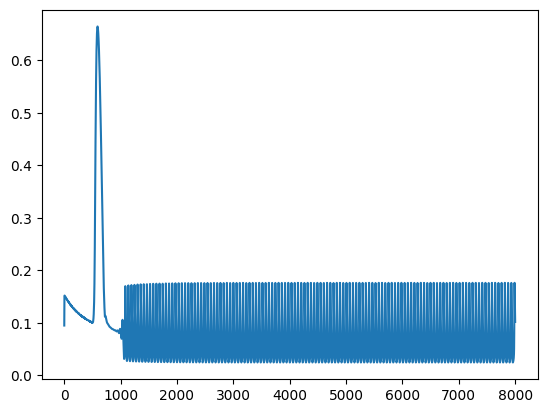

In [25]:
# Initial Conditions
y0 = [c_cyt,c_er,c_ec,ip3_cyt,g_cyt,soc_pm,cif_cyt,cif_er]

t_span = (0,8000)
t_eval = np.linspace(t_span[0],t_span[1],10000)

# Define max ip3
ip3_max = 0.04

sol = solve_ivp(ODE_SYSTEM,t_span,y0,t_eval=t_eval,args=(1,ip3_max))
plt.plot(sol.t,sol.y[0])